# Задание по программированию: Размещение баннеров

Автор: Сметанин Александр

Дата: 20.06.2018


Представим, что международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare.

Часть открытых данных есть, например, на сайте archive.org:

https://archive.org/details/201309_foursquare_dataset_umn

Файл данных fsq.zip доступен для скачивания с этой страницы.

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import MeanShift

Нас будет интересовать файл checkins.dat. Открыв его, увидим следующую структуру:

In [2]:
with open('checkins.dat', 'r') as fo:
    lines = fo.readlines()

In [3]:
lines[:6]

['   id    | user_id | venue_id |     latitude      |     longitude     |     created_at      \n',
 '---------+---------+----------+-------------------+-------------------+---------------------\n',
 '  984301 | 2041916 |     5222 |                   |                   | 2012-04-21 17:39:01\n',
 '  984222 |   15824 |     5222 |        38.8951118 |       -77.0363658 | 2012-04-21 17:43:47\n',
 '  984315 | 1764391 |     5222 |                   |                   | 2012-04-21 17:37:18\n',
 '  984234 |   44652 |     5222 |         33.800745 |         -84.41052 | 2012-04-21 17:43:43\n']

Для удобной работы с этим документом c помощью pandas построим DataFrame, удалив строки, не содержащие координат. Убедимся, что все 396634 строки с координатами считаны успешно.

In [4]:
# Make a header from the first line
header = []
for line in lines[0].split('|'):
    header.append(line.strip())

# Read the data into dataframe    
df = pd.read_csv('checkins.dat', delimiter='|', skiprows=[0, 1], names=header, skipinitialspace=True)
# Remove rows which contain Nan
df.dropna(inplace=True)

print 'Size of the dataframe:', df.shape

D:\Shef\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Size of the dataframe: (396634, 6)


Эта задача — хороший повод познакомиться с алгоритмом MeanShift, который мы обошли стороной в основной части лекций. Его описание при желании можно посмотреть в sklearn user guide, а чуть позже появится дополнительное видео с обзором этого и некоторых других алгоритмов кластеризации. Используйте MeanShift, указав bandwidth=0.1, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах.

Примечание: на 396634 строках кластеризация будет работать долго. Быть очень терпеливым не возбраняется — результат от этого только улучшится. Но для того, чтобы сдать задание, понадобится сабсет из первых 100 тысяч строк. Это компромисс между качеством и затраченным временем. Обучение алгоритма на всём датасете занимает около часа, а на 100 тыс. строк — примерно 2 минуты, однако этого достаточно для получения корректных результатов.

In [5]:
# Make subset
df_100000 = df.iloc[:100000, [3, 4]]

In [6]:
clf = MeanShift(bandwidth = 0.1, n_jobs=-1)
clf.fit(df_100000)
labels = clf.labels_
cluster_centers = clf.cluster_centers_
print 'Количество кластеров:', len(cluster_centers)
print 'Всего точек в кластерах:', len(labels)

Количество кластеров: 3230
Всего точек в кластерах: 100000


In [25]:
# save all locations into a file
with open('cluster_centers.txt', 'w') as fo:
    for cl in cluster_centers:
        fo.write('{},{}\n'.format(cl[0], cl[1]))

Некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения.

In [8]:
n_clusters = len(cluster_centers)    # number of clusters
clusters = np.empty([0,4])           # create array of clusters' data: number, latitude, longitude, member count
list_labels = labels.tolist()        # convert ndarray to list
threshold = 15                       # Threshold for member count
for i, cluster in zip(range(n_clusters), cluster_centers):
    s = list_labels.count(i)
    if s > threshold:
        clusters = np.vstack((clusters, [i, cluster[0], cluster[1], s]))
print 'Количество кластеров с числом точек больше {}: {}.'.format(threshold, clusters.shape[0])
print 'Всего точек в этих кластерах: ', clusters.sum(axis=0)[3]

Количество кластеров с числом точек больше 15: 593.
Всего точек в этих кластерах:  90884.0


Примерное распределение полученных центров кластеров по миру представлено ниже. Большинство центров располагается в левом верхнем углу, что соответствует Северной Америке.

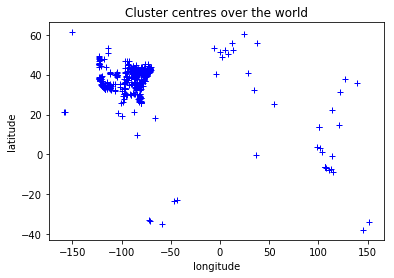

In [28]:
import matplotlib.pyplot as plt
x = clusters[:,2]
y = clusters[:,1]
plt.plot(x, y, 'b+')
plt.title('Cluster centres over the world')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

Как мы помним, 20 баннеров надо разместить близ офисов компании. Найдем на Google Maps по запросу Carnival Cruise Line адреса всех офисов:

In [10]:
office_addresses = np.array([[33.751277, -118.188740], 
                             [25.867736, -80.324116], 
                             [51.503016, -0.075479], 
                             [52.378894, 4.885084], 
                             [39.366487, 117.036146], 
                             [-33.868457, 151.205134]])

Осталось определить ближайший к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать один с наименьшим значением. Ответ в этом задании — широта и долгота этого центра, записанные через пробел.

Примечание: при подсчете расстояний и в кластеризации можно пренебречь тем, что Земля круглая, так как в точках, расположенных близко друг к другу погрешность мала, а в остальных точках значение достаточно велико.

In [13]:
# Function calculates distance between two points p1 and p2. Returns float.
# The points are ndarrays with two coordinates.
def e_dist(p1, p2):
    return np.sqrt(np.sum((p1-p2)**2))

# Function calculates distance between point and array. Returns ndarray. 
# The point and elements of array are ndarrays with two coordinates.
def a_dist(point, array):
    res = []
    for p in array:
        res.append(e_dist(p, point))
    return np.array(res)

In [14]:
n_clusters2 = len(clusters)                                      # Number of clusters
cluster_addresses = np.vstack((clusters[:,1],clusters[:,2])).T   # Make array of cluster centres

# Add columns these are distances to the offices. Each columns corresponds to one office address.
for office in office_addresses:
    d = a_dist(office, cluster_addresses)
    d = np.reshape(d, (n_clusters2, 1))
    clusters = np.hstack((clusters, d))

In [27]:
# Find a minimum distance to office for each cluster center
min_dist = np.min(clusters[:,4:], axis=1)

# Find a cluster with minimal distance
min_arg = np.argmin(min_dist)
min_cluster = clusters[min_arg,:]

# Find the nearest office coordinates for the cluster
min_off_arg = np.argmin(min_cluster[4:])
near_office = office_addresses[min_off_arg]

print 'Кластер номер {:.0f} с координатами широта = {:.3f}, долгота = {:.3f}, количество точек = {:.0f}.'.\
    format(min_cluster[0], min_cluster[1], min_cluster[2], min_cluster[3])
print 'Ближайший офис номер {} с координатами широта = {:.3f}, долгота = {:.3f}.'.\
    format(min_off_arg, near_office[0], near_office[1])
# length of a degree of longitude at latitude 34 is about 92386 meters.
print 'Расстояние от офиса до центра кластера = {:.1f} км.'.format(min_cluster[9]*92.386)

Кластер номер 413 с координатами широта = -33.861, долгота = 151.205, количество точек = 28.
Ближайший офис номер 5 с координатами широта = -33.868, долгота = 151.205.
Расстояние от офиса до центра кластера = 0.7 км.


In [16]:
# save answer into a file
with open('Week_1_answer.txt', 'w') as fo:
    fo.write(' '.join((str(min_cluster[1]), str(min_cluster[2]))))

Отобразим найденный ближайший офис на карте мира в виде красной точки. Офис располагается в Сиднее.

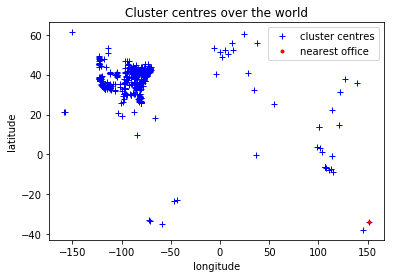

In [34]:
# Draw the office by red point 
import matplotlib.pyplot as plt
x = clusters[:,2]
y = clusters[:,1]
plt.plot(x, y, 'b+', label='cluster centres')
plt.title('Cluster centres over the world')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.plot(near_office[1], near_office[0], 'r.', label='nearest office')
plt.legend()
plt.show()